In [102]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy import dot, exp, sqrt, pi, sin

from labels import EdgeType
from checking_tools import checkLabels, checkNormals
from Trefft_tools import TrefftzSpace, TrefftzFunction,  AssembleRHS, AssembleMatrix
from geometry_tools import Edge
from meshes import testMesh, toyMesh, waveguideMesh
from meshes import ScattererType

In [105]:
R = 10.
H = 1.
rad = 0.8

c = (0,0)

quad = False
Omega = waveguideMesh(R = R, H = H, c=c, rad = rad,  scatterer_type=ScattererType.SOUND_SOFT,  quad=quad)
#Omega = testMesh(quad=quad)
# Omega = toyMesh()

In [106]:
Edges = [ Edge(Omega, e)  for e in Omega.edges ]

Checking the orientation of the labels...

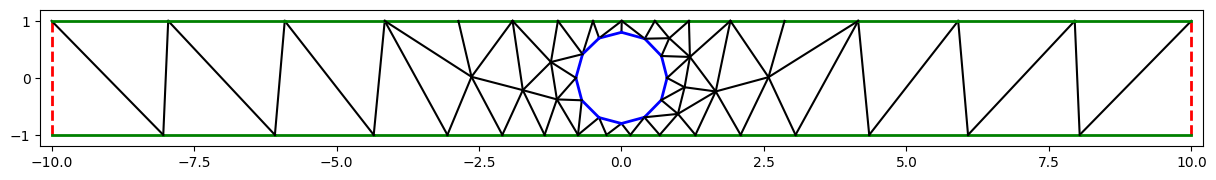

In [107]:
checkLabels(Edges)

and the orientation of the normals...

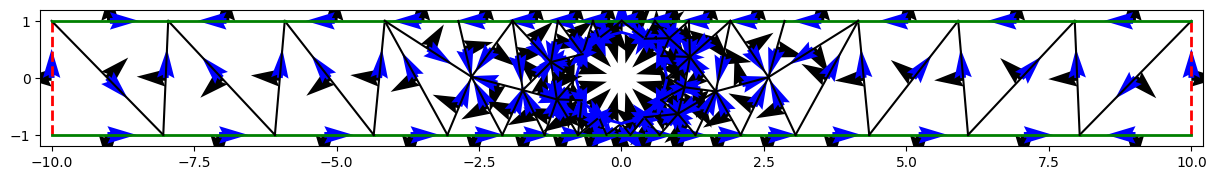

In [108]:
checkNormals(Edges)

and the definition of the "plus" and "minus" quantities...

In [109]:
  # checkPlusMinus(Edges, Baricenters) 

In [110]:
kappa_e = 8.
kappa_i = 5.


In [111]:
# #optimal angle for mode "t" : th = arcsin( lambda /  (2H)) 
# t = 1
# dth = np.arcsin( t*np.pi / (kappa_e*H))
# # optimal number of waves for mode "t":
# Nth = int(2*np.pi / dth)
# Nth 

In [112]:
Nth = 40
th = np.e/10
V = TrefftzSpace(Omega, Nth, {"Omega_i" : kappa_i , "Omega_e" : kappa_e}, th )


In [113]:
NP = 15
A = AssembleMatrix(V, Edges, Np=NP, fullsides=True, sparse=True)
NDOF = A.shape[0]


In [114]:
print(f'{NDOF=}, {np.count_nonzero(A.toarray())/NDOF**2=}')

NDOF=2680, np.count_nonzero(A.toarray())/NDOF**2=0.04923145466696369


In [115]:
Ncond = np.linalg.cond(A.toarray())
# Ncond = -1
Ncond 

2.3910419306599227e+19

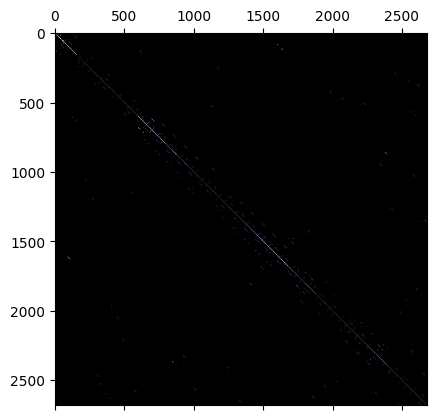

In [116]:
if type(A) is np.ndarray:
    plt.matshow(np.abs(A), cmap='bone')
else:    
    plt.matshow(np.abs(A.toarray()), cmap='bone')
# for y_ in range(0,NDOF,Nth):
#     plt.hlines(y=y_,xmin=0,xmax=NDOF,colors='r')
#     plt.vlines(x=y_,ymin=0,ymax=NDOF,colors='r')


In [117]:
t = 0
B = AssembleRHS(V, Edges, kappa_e, H, d_2=0.5, t=t, full_sides=True)

In [118]:
#DOFs = np.linalg.solve(A,B)
from scipy.sparse.linalg import bicgstab 
from scipy.sparse.linalg import spsolve 
A = A.tocsc()
# DOFs, _ = bicgstab(A,B)
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

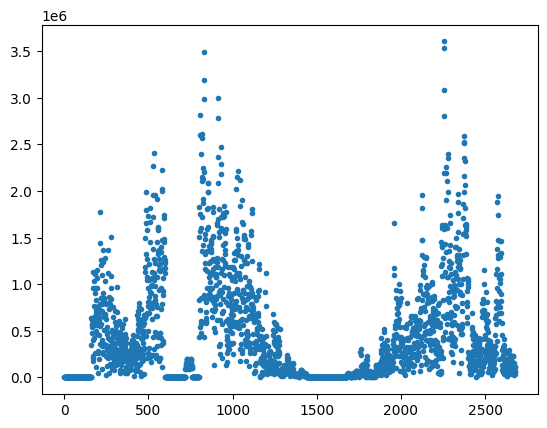

In [119]:
plt.plot(np.abs(DOFs),'.')

In [120]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(-H,H,Ny)
X, Y = np.meshgrid(x,y)

Z =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])


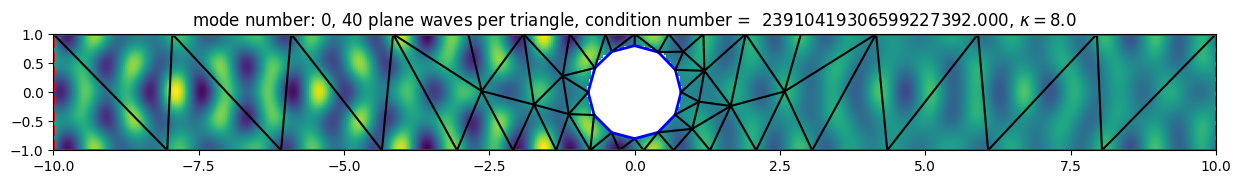

In [121]:
_, ax = plt.subplots( figsize=(15,3))

ax.imshow(np.real(Z), origin="lower", extent=[-R,R,-H,H])
#v = 1
#ax.imshow(np.real(Z), origin="lower", extent=[-R,R,-H,H], vmin=-v, vmax=v)

checkLabels(Edges, ax)
ax.axis('square')
ax.set_xlim([-R,R])
ax.set_ylim([-H,H])
plt.title(f'mode number: {t}, {Nth} plane waves per triangle, condition number = {Ncond: .3f}, $\\kappa={kappa_e:.1f}$')

save = False
if save:
    plt.savefig(f'test_{t}_{Nth}_d2.png')

In [124]:
from exact_solutions import exact_sound_soft
Z_exact = exact_sound_soft(X,Y,kappa_e, H, rad=rad, c=c, theta_inc=0, M = 40, N = 15)

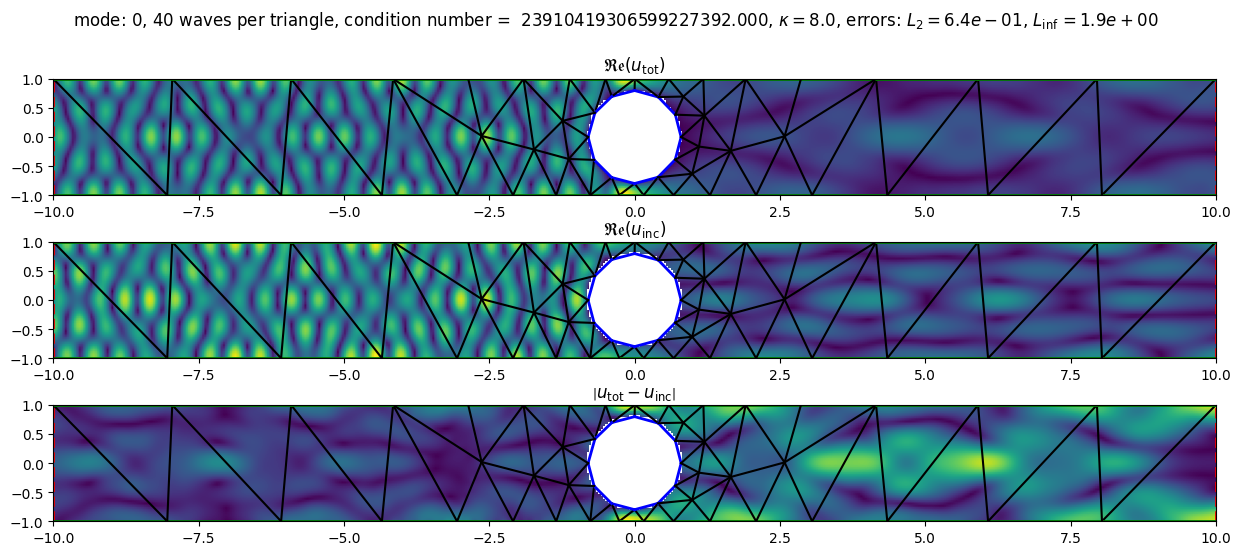

In [125]:
fig, ax = plt.subplots( nrows = 3, figsize=(15,6))

ax[0].imshow(np.abs(Z), origin="lower", extent=[-R,R,-H,H])

checkLabels(Edges, ax[0])
ax[0].axis('square')
ax[0].set_xlim([-R,R])
ax[0].set_ylim([-H,H])

Z_inc = np.exp(1j*np.sqrt(complex(kappa_e**2 - (t*np.pi/H)**2))*X)*np.cos(t*np.pi*Y/H)

diff = np.where( (X-c[0])**2 + (Y-c[1])**2> rad**2, np.abs(Z - Z_exact), 0.)

L2_err = np.sqrt(np.mean(diff**2))
L_inf_err = np.max(diff)


ax[1].imshow(np.abs(Z_exact), origin="lower", extent=[-R,R,-H,H])

checkLabels(Edges, ax[1])
ax[1].axis('square')
ax[1].set_xlim([-R,R])
ax[1].set_ylim([-H,H])



ax[2].imshow(np.abs(Z-Z_exact), origin="lower", extent=[-R,R,-H,H])

checkLabels(Edges, ax[2])
ax[2].axis('square')
ax[2].set_xlim([-R,R])
ax[2].set_ylim([-H,H])

fig.suptitle(f'mode: {t}, {Nth} waves per triangle, condition number = {Ncond: .3f}, $\\kappa={kappa_e:.1f}$, errors: $L_2={L2_err:.1e}$, $L_\\inf={L_inf_err:.1e}$')
ax[0].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$')
ax[1].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{inc}\\right)$')
ax[2].set_title('$\\left\\vert u_\\mathrm{tot}-u_\\mathrm{inc}\\right\\vert$')

save = False
if save:
    plt.savefig(f'mode_{t}_{Nth}_no_d2_no_wave_in_basis.png')

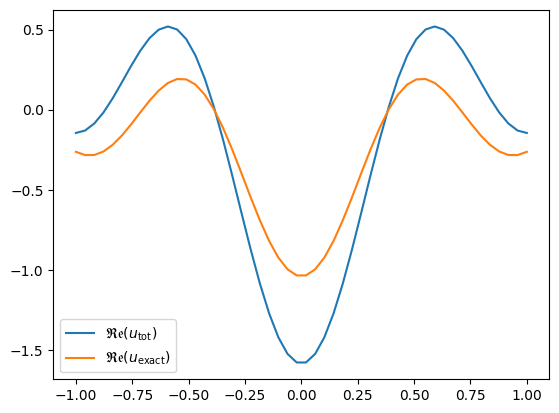

In [126]:
plt.plot(y,np.real(Z[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$')
plt.plot(y,np.real(Z_exact[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{exact}\\right)$')

plt.legend()
